In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

from sklearn.metrics import  classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

%matplotlib inline 

In [2]:
import importlib
import ids_common
importlib.reload(ids_common)

SEED = random.randint(0, 42424242)
SEED = 42
print(f'SEED = {SEED}')

SEED = 42


In [3]:
df_orig = pd.read_csv('./samples_4_github/clean_ml_sample_balanced_2_class.csv', low_memory=False)

In [4]:
df_orig['Attack_label'].value_counts()

Attack_label
1    120223
0    120223
Name: count, dtype: int64

In [5]:
df_orig['Attack_type'].value_counts()

Attack_type
Normal                   120223
DDoS_UDP                  10000
Password                  10000
XSS                       10000
DDoS_ICMP                 10000
DDoS_TCP                  10000
SQL_injection             10000
Uploading                 10000
DDoS_HTTP                 10000
Backdoor                  10000
Port_Scanning             10000
Vulnerability_scanner     10000
Ransomware                 9141
OS_Fingerprinting           724
MITM                        358
Name: count, dtype: int64

In [6]:
df_train, df_test = ids_common.ds_split(df_orig, seed=42)

dataset = {}
dataset['2_class'] = {
    'train': ids_common.make_2_class(df_train),
    'test': ids_common.make_2_class(df_test)
}

dataset['14_class'] = {
    'train':ids_common.make_14_class(df_train),
    'test':ids_common.make_14_class(df_test)
}

dataset['15_class'] = {
    'train':ids_common.make_15_class(df_train),
    'test':ids_common.make_15_class(df_test)
}


def get_data(class_type, set_type):
    X, y = dataset[class_type][set_type]
    return X.values, y.values

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

DecisionTreeClassifier:
Train score: 0.966447628355757
Test score:  0.9647951757122063
TRAIN:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     96178
           1       1.00      0.93      0.97     96178

    accuracy                           0.97    192356
   macro avg       0.97      0.97      0.97    192356
weighted avg       0.97      0.97      0.97    192356

TEST:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     24045
           1       1.00      0.93      0.96     24045

    accuracy                           0.96     48090
   macro avg       0.97      0.96      0.96     48090
weighted avg       0.97      0.96      0.96     48090



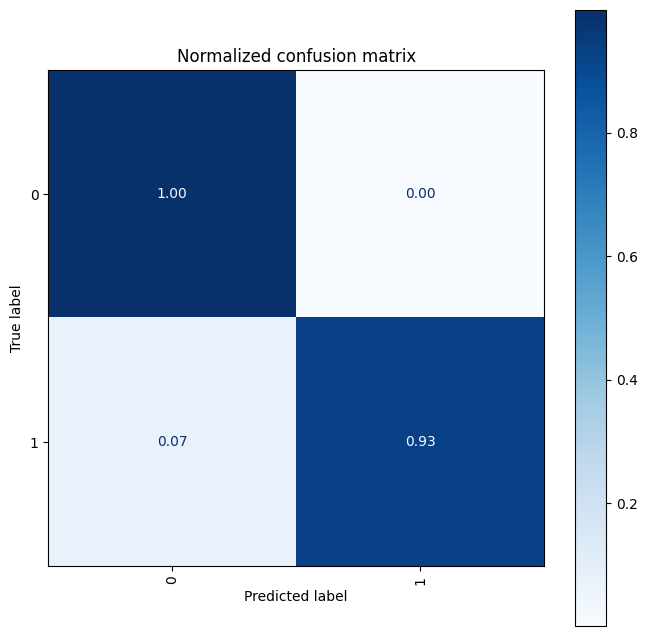

################################################################################


In [8]:
class_2 = DecisionTreeClassifier(
        **{'criterion': 'entropy', 'max_depth': 16}, random_state=SEED)

X_train, y_train = get_data('2_class', 'train')
X_test, y_test = get_data('2_class', 'test')

class_2.fit(X_train, y_train)

y_train_predict = class_2.predict(X_train)
y_test_predict = class_2.predict(X_test)

print(f'{class_2.__class__.__name__}:')
print(f'Train score: {class_2.score(X_train, y_train)}')
print(f'Test score:  {class_2.score(X_test, y_test)}')

ids_common.report(y_train, y_train_predict, y_test, y_test_predict)
ids_common.plot_cm(y_test, y_test_predict)

print('#'*80)

RandomForestClassifier:
Train score: 0.9999792052236478
Test score:  0.917238511124974
TRAIN:
                       precision    recall  f1-score   support

             Backdoor       1.00      1.00      1.00      8000
            DDoS_HTTP       1.00      1.00      1.00      8000
            DDoS_ICMP       1.00      1.00      1.00      8000
             DDoS_TCP       1.00      1.00      1.00      8000
             DDoS_UDP       1.00      1.00      1.00      8000
                 MITM       1.00      1.00      1.00       286
    OS_Fingerprinting       1.00      1.00      1.00       579
             Password       1.00      1.00      1.00      8000
        Port_Scanning       1.00      1.00      1.00      8000
           Ransomware       1.00      1.00      1.00      7313
        SQL_injection       1.00      1.00      1.00      8000
            Uploading       1.00      1.00      1.00      8000
Vulnerability_scanner       1.00      1.00      1.00      8000
                  XSS  

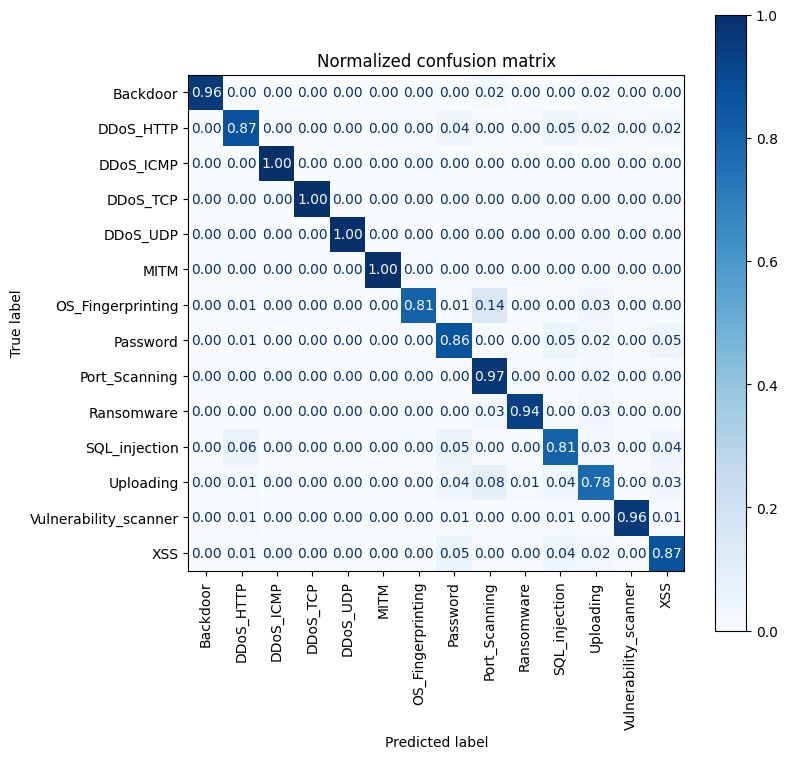

################################################################################


In [9]:
class_14 = RandomForestClassifier(
        **{'criterion': 'entropy', 'max_depth': 128, 'max_features': 'log2', 'n_estimators': 100},random_state=SEED)

X_train, y_train = get_data('14_class', 'train')
X_test, y_test = get_data('14_class', 'test')

class_14.fit(X_train, y_train)

y_train_predict = class_14.predict(X_train)
y_test_predict = class_14.predict(X_test)

print(f'{class_14.__class__.__name__}:')
print(f'Train score: {class_14.score(X_train, y_train)}')
print(f'Test score:  {class_14.score(X_test, y_test)}')

ids_common.report(y_train, y_train_predict, y_test, y_test_predict)
ids_common.plot_cm(y_test, y_test_predict)

print('#'*80)

RandomForestClassifier:
Train score: 0.9999896026118239
Test score:  0.9454772301933874
TRAIN:
                       precision    recall  f1-score   support

             Backdoor       1.00      1.00      1.00      8000
            DDoS_HTTP       1.00      1.00      1.00      8000
            DDoS_ICMP       1.00      1.00      1.00      8000
             DDoS_TCP       1.00      1.00      1.00      8000
             DDoS_UDP       1.00      1.00      1.00      8000
                 MITM       1.00      1.00      1.00       286
               Normal       1.00      1.00      1.00     96178
    OS_Fingerprinting       1.00      1.00      1.00       579
             Password       1.00      1.00      1.00      8000
        Port_Scanning       1.00      1.00      1.00      8000
           Ransomware       1.00      1.00      1.00      7313
        SQL_injection       1.00      1.00      1.00      8000
            Uploading       1.00      1.00      1.00      8000
Vulnerability_scanner 

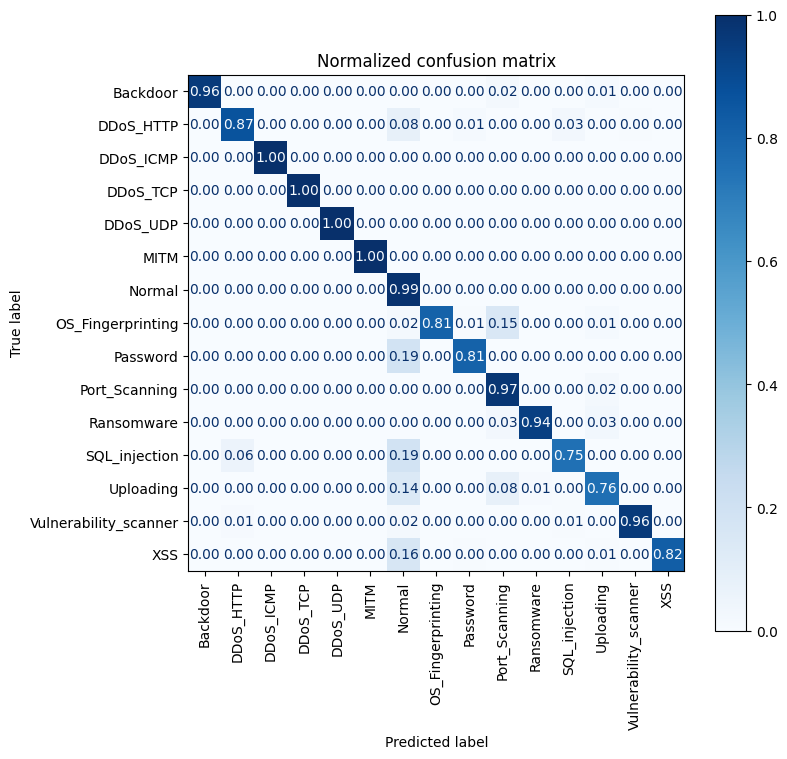

################################################################################


In [10]:
class_15 = RandomForestClassifier(
        **{'criterion': 'entropy', 'max_depth': 128, 'max_features': 'log2', 'n_estimators': 100},random_state=SEED)

X_train, y_train = get_data('15_class', 'train')
X_test, y_test = get_data('15_class', 'test')
class_15.fit(X_train, y_train)

y_train_predict = class_15.predict(X_train)
y_test_predict = class_15.predict(X_test)

print(f'{class_15.__class__.__name__}:')
print(f'Train score: {class_15.score(X_train, y_train)}')
print(f'Test score:  {class_15.score(X_test, y_test)}')

ids_common.report(y_train, y_train_predict, y_test, y_test_predict)
ids_common.plot_cm(y_test, y_test_predict)

print('#'*80)

In [11]:
def eval_cascade(detector, classifier):
    y_class_2_test = df_test[ids_common.target_label_2_class]
    y_class_15_test = df_test[ids_common.target_label_15_class]

    X_test = df_test.drop([ids_common.target_label_2_class, 
                    ids_common.target_label_15_class], 
                    axis=1, inplace=False)


    y_class_2_predict = detector.predict(X_test)

    ds_class_14 = df_test[y_class_2_predict==1]
    X_class_14 = ds_class_14.drop(
                    [ids_common.target_label_2_class, 
                    ids_common.target_label_15_class], 
                    axis=1, inplace=False)

    y_class_14_predict = classifier.predict(X_class_14)


    y_class_15_predict = pd.Series(y_class_2_predict, index=X_test.index.copy())
    y_class_15_predict = y_class_15_predict.map(lambda x: 'Normal' if x==0 else 'Attack')
    y_class_15_predict.loc[X_class_14.index] = y_class_14_predict

    print('DETECTION:')
    print(classification_report(y_class_2_test, y_class_2_predict))
    ids_common.plot_cm(y_class_2_test, y_class_2_predict)

    print('CLASSIFICATION:')
    print(classification_report(y_class_15_test, y_class_15_predict))
    ids_common.plot_cm(y_class_15_test, y_class_15_predict)

c:\Users\pro17\anaconda3\envs\ids\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\pro17\anaconda3\envs\ids\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


DETECTION:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     24045
           1       1.00      0.93      0.96     24045

    accuracy                           0.96     48090
   macro avg       0.97      0.96      0.96     48090
weighted avg       0.97      0.96      0.96     48090



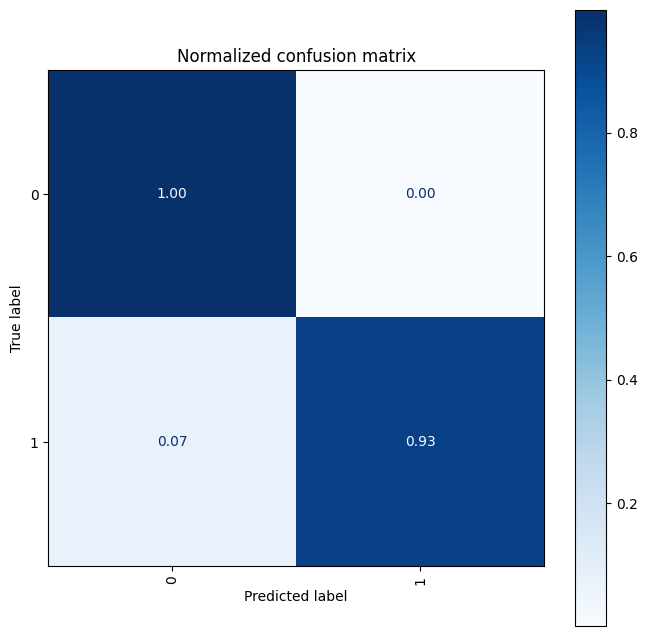

CLASSIFICATION:
                       precision    recall  f1-score   support

             Backdoor       0.99      0.96      0.98      2000
            DDoS_HTTP       0.93      0.86      0.89      2000
            DDoS_ICMP       1.00      1.00      1.00      2000
             DDoS_TCP       1.00      1.00      1.00      2000
             DDoS_UDP       1.00      1.00      1.00      2000
                 MITM       1.00      1.00      1.00        72
               Normal       0.93      1.00      0.97     24045
    OS_Fingerprinting       0.98      0.81      0.89       145
             Password       0.98      0.80      0.88      2000
        Port_Scanning       0.88      0.97      0.92      2000
           Ransomware       0.98      0.94      0.96      1828
        SQL_injection       0.95      0.76      0.84      2000
            Uploading       0.91      0.75      0.83      2000
Vulnerability_scanner       0.99      0.96      0.98      2000
                  XSS       0.99      

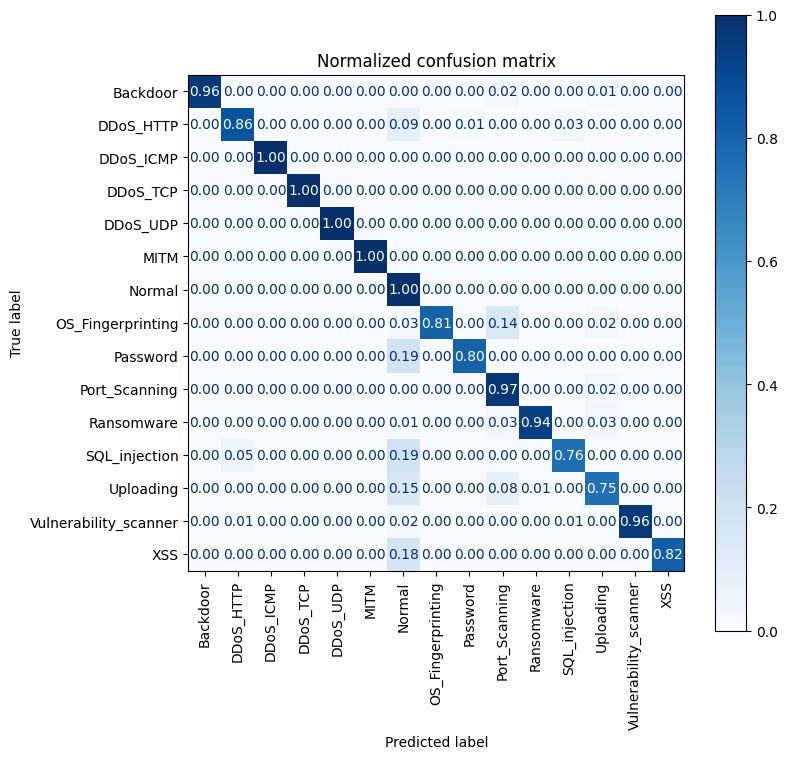

In [12]:
# combined detection with classification
y_class_2_test = df_test[ids_common.target_label_2_class]
y_class_15_test = df_test[ids_common.target_label_15_class]

X_test = df_test.drop([ids_common.target_label_2_class, 
                  ids_common.target_label_15_class], 
                  axis=1, inplace=False)


y_class_2_predict = class_2.predict(X_test)

ds_class_14 = df_test[y_class_2_predict==1]
X_class_14 = ds_class_14.drop(
                [ids_common.target_label_2_class, 
                  ids_common.target_label_15_class], 
                  axis=1, inplace=False)

y_class_14_predict = class_14.predict(X_class_14)


y_class_15_predict = pd.Series(y_class_2_predict, index=X_test.index.copy())
y_class_15_predict = y_class_15_predict.map(lambda x: 'Normal' if x==0 else 'Attack')
y_class_15_predict.loc[X_class_14.index] = y_class_14_predict

print('DETECTION:')
print(classification_report(y_class_2_test, y_class_2_predict))
ids_common.plot_cm(y_class_2_test, y_class_2_predict)

print('CLASSIFICATION:')
print(classification_report(y_class_15_test, y_class_15_predict))
ids_common.plot_cm(y_class_15_test, y_class_15_predict)



In [18]:
# Execution Time 3m 15.7s

# Overhead Time 120ms
X_test = df_test.drop([ids_common.target_label_2_class, 
                  ids_common.target_label_15_class], 
                  axis=1, inplace=False)

class_15_time = []
class_15_predicts = []
for index, row in X_test.iterrows():
    t = time.time()
    print(row)
    class_15_predicts.append(class_15.predict(pd.DataFrame(row).T))
    # class_15_predicts.append(class_15.predict(row.to_numpy().reshape(1, -1)))

    class_15_time.append(time.time() - t)

    print(class_15_predicts, class_15_time)
    break

print(class_15_time[:10])

arp.opcode                                      0.0
arp.hw.size                                     0.0
icmp.checksum                                   0.0
icmp.seq_le                                     0.0
http.content_length                             0.0
http.response                                   0.0
http.tls_port                                   0.0
tcp.ack                                       150.0
tcp.ack_raw                            1455594634.0
tcp.checksum                                24249.0
tcp.connection.fin                              1.0
tcp.connection.rst                              0.0
tcp.connection.syn                              0.0
tcp.connection.synack                           0.0
tcp.flags                                      17.0
tcp.flags.ack                                   1.0
tcp.len                                         0.0
tcp.seq                                       108.0
udp.stream                                      0.0
udp.time_del

c:\Users\pro17\anaconda3\envs\ids\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [31]:
#cascade
# Execution Time 1m 41.8s

# Overhead Time 97ms

X_test = df_test.drop([ids_common.target_label_2_class, 
                  ids_common.target_label_15_class], 
                  axis=1, inplace=False)

class_casdade_time = []
class_cascade_predicts = []
for index, row in X_test.iterrows():
    t = time.time()
    
    detection = class_2.predict(row.to_numpy().reshape(1, -1))

    if detection == 1:
        class_cascade_predicts.append(class_14.predict(row.to_numpy().reshape(1, -1)))
    else:
        class_cascade_predicts.append(detection)
    
    class_casdade_time.append(time.time() - t)

print(class_casdade_time[:10])

[0.005787372589111328, 0.003742218017578125, 0.0046274662017822266, 0.0005583763122558594, 0.00022292137145996094, 0.008107662200927734, 0.00025582313537597656, 0.00019431114196777344, 0.00789022445678711, 0.00020384788513183594]


In [65]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier()

X_train, y_train = get_data('15_class', 'train')
dummy.fit(X_train, y_train)

X_test = df_test.drop([ids_common.target_label_2_class, 
                  ids_common.target_label_15_class], 
                  axis=1, inplace=False)

dummy_time = []
dummy_predicts = []
for index, row in X_test.iterrows():
    t = time.time()
    
    dummy_predicts.append(dummy.predict(row.to_numpy().reshape(1, -1)))

    dummy_time.append(time.time() - t)


print(dummy_time[:10])

[0.0001652240753173828, 3.504753112792969e-05, 2.9802322387695312e-05, 2.765655517578125e-05, 2.7418136596679688e-05, 2.6941299438476562e-05, 2.5987625122070312e-05, 2.86102294921875e-05, 2.6702880859375e-05, 2.6226043701171875e-05]


In [66]:
def stats(tt):
    print(f'   min: {np.min(tt):0.5f}')
    print(f'   max: {np.max(tt):0.5f}')
    print(f'  mean: {np.mean(tt):0.5f}')
    print(f'median: {np.median(tt):0.5f}')
    print(f'   std: {np.std(tt):0.5f}')
    print(f' total: {np.sum(tt):0.5f}')

In [67]:
print('Classification 15:')
stats(class_15_time)
print('-'*80)

print('Classification cascade:')
stats(class_casdade_time)

print('-'*80)

print('Classification dummy:')
stats(dummy_time)

Classification 15:
   min: 0.00326
   max: 0.03848
  mean: 0.00400
median: 0.00353
   std: 0.00144
 total: 192.36550
--------------------------------------------------------------------------------
Classification cascade:
   min: 0.00011
   max: 0.03510
  mean: 0.00205
median: 0.00021
   std: 0.00232
 total: 98.71616
--------------------------------------------------------------------------------
Classification dummy:
   min: 0.00002
   max: 0.00181
  mean: 0.00003
median: 0.00002
   std: 0.00001
 total: 1.30369


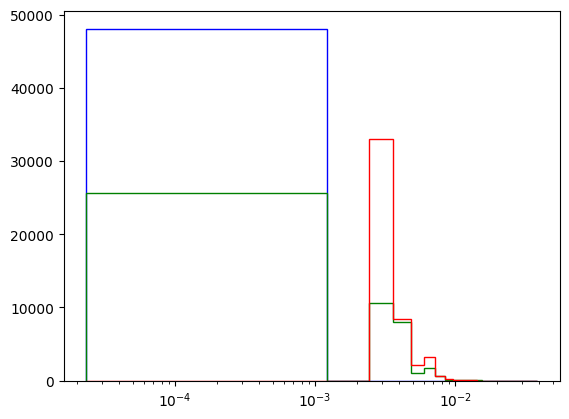

In [72]:

n_bins = 32
colors = ['red', 'green', 'blue']
x = [class_15_time, class_casdade_time, dummy_time]
names = ['class_15', 'cascade', 'dummy']
# Generate two normal distributions
plt.hist(x, n_bins, histtype='step', color=colors, label=names)
plt.xscale('log')
plt.show()